# Kickstarter projects classification model

In this coursework ([4iz565](http://4iz565.gitlab.io/)) we will try to find the best model to predict if projects on [Kickstarter](https://www.kickstarter.com/) will be successful or not.

We use dataset from kaggle with more than 300 000 Kickstarter projects.

- [Link to the dataset on kaggle](https://www.kaggle.com/kemical/kickstarter-projects)

## Authors
- Aleksandra Golofaeva (gola03@vse.cz)
- Dmitrij Tkačenko (tkad06@vse.cz)

## Requirements (packages) for running Python scripts
- python3
- pandas
- matplotlib
- sklearn
- datetime

## Goal of the classification

In this coursework we try to create classification model, which will **predict if a project from the Kickstarter portal success or fail**.

We preprocess dataset to work just with relevant attributes. We derive new columns and remove redundant ones. Also, we should handle missing values.

Then, we use and compare two fitting and common algorithms to train model.

We select one classifier and tune it's metaparameters.

And finally, we evaluate selected and tuned model.

## Discover dataset

Before we will train any models, we should discover our dataset, then we will proceed to preprocessing our data.

But first, lets import Kickstarter projects dataset from a `.csv` file and save as a pandas data frame `ksp`.

In [266]:
import pandas as pd

# we know that first column is a row ID, so we set index_col to 0.
ksp = pd.read_csv("ks-projects-201801.csv", index_col=0)
# return data frame with our data
ksp.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


We see our target column **state** in above data frame. This categorical attribute will be crucial for us while training prediction model and then testing that model.

Let's see what values it has. We create bar plot here to visualize our target values and their counts.

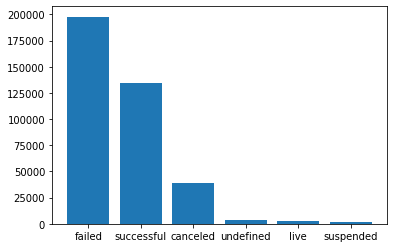

In [267]:
import matplotlib.pyplot as plt

ksp_target_counts = ksp['state'].value_counts()
plt.bar(ksp_target_counts.index, ksp_target_counts.values)
plt.show()

As we see in a bar plot above we have 6 target values here (categories).

- failed - it has reached deadline, but pledge was not fullfilled
- successful
- canceled - canceled by a project owner, before deadline reach
- undefined
- live - project active in the time dataset was created
- suspended - suspended due to Trust & Safety team uncovers evidence that it is in violation of Kickstarter's rules

Now, we know for sure, that we should get rid of rows whose target value is **live**. We can then extract those rows and use them as a test data.

It seems reasonable to transform **canceled** projects to **failed**, same with **suspended**.

*🚧 Nejsem si jistej se suspended... Jestli to nenechat zvlast?*

## Preprocessing

1. We would like to have just two target values - **successful** and **failed**.
2. We assign one of above states to rows with **undefined** rows.
3. We derive new columns and remove redundant ones.
4. We handle missing values (if present).
5. We extract rows with **live** state and save them to a variable. We will use them for testing in the end.

### Merge states

Here, we set canceled and suspended projects as failed ones.

In [268]:
# create copy for preprocessing
ksp_pre = ksp.copy()

# get current sum of rows for each state
canceled_proj_len = len(ksp_pre[ksp_pre['state'] == 'canceled']) 
suspended_proj_len = len(ksp_pre[ksp_pre['state'] == 'suspended'])
failed_proj_len = len(ksp_pre[ksp_pre['state'] == 'failed'])

# set failed state instead of canceled state
ksp_pre.loc[ksp['state'] == 'canceled', ['state']] = 'failed'
# set failed state instead of suspended state
ksp_pre.loc[ksp['state'] == 'suspended', ['state']] = 'failed'

assert len(ksp_pre[ksp_pre['state'] == 'canceled']) == 0, "Canceled rows length should be 0"
assert len(ksp_pre[ksp_pre['state'] == 'suspended']) == 0, "Suspended rows length should be 0"
assert len(ksp_pre[ksp_pre['state'] == 'failed']) == failed_proj_len + suspended_proj_len + canceled_proj_len
print("Canceled and suspended projects successfully converted to failed projects.")
print("Failed projects sum: ", failed_proj_len + suspended_proj_len + canceled_proj_len)

Canceled and suspended projects successfully converted to failed projects.
Failed projects sum:  238344


### Handle undefined rows

In [269]:
# Print projects with undefined state
ksp_pre[ksp_pre['state'] == 'undefined'].head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00


We apply this rules on projects with state undefined:
- country will be set as currency without last letter
    - *currency: EUR, country: EU* or
    - *currency: CAD, country: CA*
- if project's **goal is reached then state is successful**, otherwise failed.

Let's start with first rule.

In [270]:
# remove last character from currency and resulted string set as a country
ksp_pre.loc[ksp_pre['state'] == 'undefined', 'country'] = ksp_pre.apply(lambda p: p['currency'][:-1], axis=1)
# print undefined projects
ksp_pre.loc[ksp_pre['state'] == 'undefined',['state', 'currency', 'country']].head()

,state,currency,country
ID,,,
1000694855,undefined,USD,US
100149523,undefined,AUD,AU
1003023003,undefined,USD,US
1003130892,undefined,USD,US
1003629045,undefined,USD,US


We see now country values derived from currency.

And now, we apply second rule - assign successful or failed state based on goal and pledge.

In [271]:
# get current sums of states
undefined_proj_len = len(ksp_pre[ksp_pre['state'] == 'undefined'].index)
success_or_failed_len = len(ksp_pre[(ksp_pre['state'] == 'successful') | (ksp_pre['state'] == 'failed')].index)

if undefined_proj_len != 0:
    # apply first rule
    ksp_pre.loc[ksp_pre['state'] == 'undefined', 'state'] = ksp_pre.apply(lambda p: 'failed' if (p['usd_goal_real'] > p['usd_pledged_real']) else 'successful', axis=1)

# test that everything is right
assert len(ksp_pre[ksp_pre['state'] == 'undefined'].index) == 0, "Undefined rows length should be 0"
assert len(ksp_pre.loc[(ksp_pre['state'] == 'successful') | (ksp_pre['state'] == 'failed')].index) == success_or_failed_len + undefined_proj_len
print("Project with state undefined successfuly identified.")


Project with state undefined successfuly identified.


### Remove, derive columns

We have here multiple columns, which does not have any meaning for our model or even could have negative effect on our model.

- `name` - A lot of distinct values (could be even unique), not categorical, not numerical...
- `backers` and `pledged` - If one of them is 0, then the other one too. It shows end-state of a project, but in the beginning it always equals 0. So all new data, that we have to predict will be predicted as Failed.

Column `launched` gives us information about project beginning datetime on the kickstarter. It's 99.9% probability that it would be an unique value, because it has even seconds. Also, it gives us nothing for our prediction model.

**BUT We can use `launched` values in the other way.** We have available **deadline** date too. We will derive a new column called **duration**, where we pass the difference between launched and deadline dates. The difference will be presented in days. Thus, duration represents how many days a project was/will be active on the Kickstarter.

Next, we see some duplicated columns.
- `usd_goal_real` -> `goal` converted to $
- `usd_pledged_real` -> `pledged` converted to $ by Fixer.io API
- `usd_pledged` -> `pledged` converted to $ by the kickstarter

We mentioned above that pledged value is useless for us, so duplicate columns like usd_pledged_real and usd_pledged too. We can remove them.

At this point currency column does not make sense for us anymore, because we have all project's goals converted to USD. Country column will do the job for categorization.

Now, we remove mentioned columns.

🚧 *Poznamka pro nas: `backers` a `usd_pledged_real` asi nemuzeme zahrnovat do modelu. Predstavuji totiz stav ke konci projektu, ale realne nova data budou vstupovat u obou sloupcu s hodnotou 0 - to by pak model vzdy vyhodnocoval jako Failed nebo Canceled. Ted me ale ani nenapada jak bychom tyto hodnoty mohli vyuzit k derivaci jinych hodnot. Asi nijak.. :(*

In [272]:

ksp_pre = ksp_pre.drop(['name', 'currency', 'goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'backers'], axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real
ID,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


At this point we can derive **duration** column and remove `launched` and `deadline` columns.

In [273]:
from datetime import datetime

# get datetime strings, convert them to datetime objects and return duration in days between two days
def parse_and_get_duration_in_days(from_date_str, to_date_str):
    from_date = datetime.strptime(from_date_str, '%Y-%m-%d %H:%M:%S')
    to_date = datetime.strptime(to_date_str, '%Y-%m-%d')
    duration = to_date - from_date
    return duration.days

# create new column duration and use function above to apply duration value derived from launched and deadline columns
ksp_pre['duration'] = ksp_pre.apply(lambda x: parse_and_get_duration_in_days(x['launched'], x['deadline']), axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real,duration
ID,,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,58
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00,59
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00,44
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00,29
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00,55


In the table above we see new `duration` column.

Next, we derive column `launched_month` to have information about time of the year a project was launched.

In [274]:
# get datetime strings, convert them to datetime objects and return duration in days between two days
def get_launched_month(launched_date_str):
    launched_date = datetime.strptime(launched_date_str, '%Y-%m-%d %H:%M:%S')
    return launched_date.month

ksp_pre['launched_month'] = ksp_pre.apply(lambda x: get_launched_month(x['launched']), axis=1)

ksp_pre.head()

,category,main_category,deadline,launched,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,,,
1000002330,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95,58,8
1000003930,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00,59,9
1000004038,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00,44,1
1000007540,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00,29,3
1000011046,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00,55,7


We have derived two new columns from dates provided by the dataset - duration and launched_month.

We can remove launched and deadline columns as we do not need them anymore.

In [275]:
# remove launched and deadline columns
ksp_pre = ksp_pre.drop(['launched', 'deadline'], axis=1)

### Categorical to numerical

In [276]:
# here we will save all dictionaries so we can use it later (two way mapping)
replace_dictionary = {}

# set columns we want to convert from string categories to numerical categories
columns_to_replace = ['country', 'main_category', 'category']

# help function for converting
def replace_categorical_to_num(column):
    # store category names to a list
    labels = ksp_pre[column].astype('category').cat.categories.tolist()
    # make mapping using dictionary comprehensions ({category: unique number})
    replace_map_comp = {column : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    # just save category dictionary for further usage
    replace_dictionary[column] = replace_map_comp[column]
    # use mapping function to replace categories for unique numbers
    ksp_pre.replace(replace_map_comp, inplace=True)

# iterate through columns and call help function
for c in columns_to_replace:
    replace_categorical_to_num(c)

ksp_pre.head()

,category,main_category,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,
1000002330,109,13,failed,11,1533.95,58,8
1000003930,94,7,failed,24,30000.00,59,9
1000004038,94,7,failed,24,45000.00,44,1
1000007540,91,11,failed,24,5000.00,29,3
1000011046,56,7,failed,24,19500.00,55,7


### Handle missing values

**@TODO**

### Extract "live" projects

In [277]:
# create copy of a live projects and drop them from ksp dataset
old_ksp_len = len(ksp_pre)
live_projects_index = ksp_pre[ksp_pre['state'] == 'live'].index
ksp_live = ksp_pre.filter(items=live_projects_index, axis=0)
ksp_live.head()

,category,main_category,state,country,usd_goal_real,duration,launched_month
ID,,,,,,,
1000149007,96,13,live,4,2396.36,59,11
1000761521,143,7,live,24,5000.00,44,12
1002183790,70,7,live,11,1159.38,17,12
1002599057,56,7,live,24,2000.00,59,12
1002629894,71,1,live,17,52.32,15,12


In [278]:
ksp_pre.drop(ksp_pre[ksp_pre['state'] == 'live'].index, inplace=True, axis=0)
new_ksp_len = len(ksp_pre)
assert old_ksp_len - new_ksp_len == len(ksp_live), "Something went wrong when extracting live projects from a datase. Lengths do not match!"
print("✅ 'live' projects extracted successfully.")
print("KSP data length before: " + str(old_ksp_len))
print("KSP data length after: " + str(new_ksp_len))
print("KSP 'live' data length: " + str(len(ksp_live)))

✅ 'live' projects extracted successfully.
KSP data length before: 378661
KSP data length after: 375862
KSP 'live' data length: 2799


## Model building

We have preprocessed our Kickstarter projects dataset, so we can pass on to the most interesting part - model building.

We will try to build model based on _ and _ algorithms.

*🚧 Dopsat, ktery algoritmy nakonec pouzijeme.*

In [292]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

split_random_state=24

# split target data (state) from main dataset collection
y = ksp_pre[['state']]
X = ksp_pre.drop(['state'], axis=1)

# convert categorical data to numerical
y = pd.get_dummies(y)
y = y.drop('state_failed', axis=1)
# X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=split_random_state, stratify=y)
# knn = KNeighborsClassifier(n_neighbors=4)
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)
# knn.score(X_test, y_test)

ridge = LogisticRegression().fit(X_train, y_train.values.ravel())
ridge.score(X_test, y_test)

/home/dimot9/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.644584123183345